# Traffic Data Cleaning & Feature Engineering

In [4]:
"""COMPLETE TRAFFIC PREDICTION PROJECT"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb

# Time Series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Deep Learning
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    LSTM_AVAILABLE = True
except:
    LSTM_AVAILABLE = False
    print("TensorFlow not available - LSTM will be skipped")

# Weather API
import requests

# PART 1: DATA CLEANING & PREPROCESSING

In [5]:
# 1.1 Load Raw Data
print("\n1.1 Loading Raw Data...")
df_raw = pd.read_csv('Dataset_Uber Traffic.csv')

print(f"✓ Data loaded: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")
print("\nFirst 5 rows:")
print(df_raw.head())
print("\nData types:")
print(df_raw.dtypes)
print("\nBasic statistics:")
print(df_raw.describe())



1.1 Loading Raw Data...
✓ Data loaded: (48120, 4)
Columns: ['DateTime', 'Junction', 'Vehicles', 'ID']

First 5 rows:
        DateTime  Junction  Vehicles           ID
0  01/11/15 0:00         1        15  20151101001
1  01/11/15 1:00         1        13  20151101011
2  01/11/15 2:00         1        10  20151101021
3  01/11/15 3:00         1         7  20151101031
4  01/11/15 4:00         1         9  20151101041

Data types:
DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

Basic statistics:
           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10


In [6]:
# 1.2 Clean Data
print("\n1.2 Cleaning Data...")

# Check missing values
print(f"Missing values:\n{df_raw.isnull().sum()}")

# Remove duplicates
duplicates = df_raw.duplicated().sum()
df_clean = df_raw.drop_duplicates()
print(f"✓ Removed {duplicates} duplicates")

# Correct data types
df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'], format='%d/%m/%y %H:%M')
print("✓ DateTime converted")

print(f"Clean data shape: {df_clean.shape}")


1.2 Cleaning Data...
Missing values:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64
✓ Removed 0 duplicates
✓ DateTime converted
Clean data shape: (48120, 4)


In [7]:
# 1.3 Aggregate Traffic Data
print("\n1.3 Aggregating Traffic Data by Hour and Junction...")

# Data is already hourly, but let's ensure it's properly aggregated
df_agg = df_clean.groupby(['DateTime', 'Junction']).agg({
    'Vehicles': 'sum'
}).reset_index()

df_agg.rename(columns={'Vehicles': 'total_vehicles'}, inplace=True)

print(f"✓ Aggregated data: {df_agg.shape}")
print(f"Date range: {df_agg['DateTime'].min()} to {df_agg['DateTime'].max()}")
print(f"Junctions: {sorted(df_agg['Junction'].unique())}")
print(f"Traffic range: {df_agg['total_vehicles'].min()} - {df_agg['total_vehicles'].max()}")
print(f"Traffic mean: {df_agg['total_vehicles'].mean():.2f}")


1.3 Aggregating Traffic Data by Hour and Junction...
✓ Aggregated data: (48120, 3)
Date range: 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Junctions: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Traffic range: 1 - 180
Traffic mean: 22.79


In [8]:
# 1.4 Save Cleaned Data
df_agg.to_csv('traffic_cleaned.csv', index=False)
print("✓ Cleaned data saved to 'traffic_cleaned.csv'")

✓ Cleaned data saved to 'traffic_cleaned.csv'


# PART 2: FEATURE ENGINEERING

In [9]:
df_features = df_agg.copy()

# 2.1 Time-based Features
print("\n2.1 Creating Time-based Features...")

df_features['hour'] = df_features['DateTime'].dt.hour
df_features['day_of_week'] = df_features['DateTime'].dt.dayofweek  # 0=Monday
df_features['month'] = df_features['DateTime'].dt.month
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
df_features['is_rush_hour'] = (((df_features['hour'] >= 7) & (df_features['hour'] <= 9)) |
                                 ((df_features['hour'] >= 17) & (df_features['hour'] <= 19))).astype(int)

print("✓ Created: hour, day_of_week, month, is_weekend, is_rush_hour")


2.1 Creating Time-based Features...
✓ Created: hour, day_of_week, month, is_weekend, is_rush_hour


In [10]:
# 2.2 Lag Features (PROPERLY - only past data)
print("\n2.2 Creating Lag Features (past data only)...")

# Sort by junction and time
df_features = df_features.sort_values(['Junction', 'DateTime'])

# Create lag features by junction
for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
    df_features[f'lag_{lag}h'] = df_features.groupby('Junction')['total_vehicles'].shift(lag)

print("✓ Created: lag_1h, lag_24h, lag_168h")


2.2 Creating Lag Features (past data only)...
✓ Created: lag_1h, lag_24h, lag_168h


In [11]:
# 2.3 Rolling Features (PROPERLY - shifted to avoid leakage)
print("\n2.3 Creating Rolling Features (past data only)...")

for window in [3, 24]:  # 3 hours, 24 hours
    df_features[f'rolling_mean_{window}h'] = df_features.groupby('Junction')['total_vehicles'].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).mean()
    )

print("✓ Created: rolling_mean_3h, rolling_mean_24h")


2.3 Creating Rolling Features (past data only)...
✓ Created: rolling_mean_3h, rolling_mean_24h


In [12]:
# 2.4 Cyclical Encoding
print("\n2.4 Creating Cyclical Encoding...")

df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)

print("✓ Created: hour_sin, hour_cos, day_sin, day_cos")


2.4 Creating Cyclical Encoding...
✓ Created: hour_sin, hour_cos, day_sin, day_cos


In [13]:
# 2.5 Junction Encoding
print("\n2.5 Creating Junction Encoding...")

junction_dummies = pd.get_dummies(df_features['Junction'], prefix='junction')
df_features = pd.concat([df_features, junction_dummies], axis=1)

print(f"✓ Created junction dummy variables")

print(f"\nTotal features created: {df_features.shape[1]}")
print(f"Feature columns: {[col for col in df_features.columns if col not in ['DateTime', 'Junction', 'total_vehicles']]}")


2.5 Creating Junction Encoding...
✓ Created junction dummy variables

Total features created: 21
Feature columns: ['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'lag_1h', 'lag_24h', 'lag_168h', 'rolling_mean_3h', 'rolling_mean_24h', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'junction_1', 'junction_2', 'junction_3', 'junction_4']


In [14]:
# Save engineered features
df_features.to_csv('traffic_features.csv', index=False)
print("\n✓ Features saved to 'traffic_features.csv'")


✓ Features saved to 'traffic_features.csv'


# PART 3: DATA COLLECTION & INTEGRATION (Weather + Events)


In [15]:
# 3.1 Weather Data
print("\n3.1 Fetching Weather Data...")

def get_weather_data(start_date, end_date, lat=51.5074, lon=-0.1278):
    """Fetch weather data from Open-Meteo API"""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': 'temperature_2m,precipitation,relative_humidity_2m,wind_speed_10m',
        'timezone': 'auto'
    }

    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()

        weather_df = pd.DataFrame({
            'DateTime': pd.to_datetime(data['hourly']['time']),
            'temperature': data['hourly']['temperature_2m'],
            'precipitation': data['hourly']['precipitation'],
            'humidity': data['hourly']['relative_humidity_2m'],
            'wind_speed': data['hourly']['wind_speed_10m']
        })

        return weather_df
    except Exception as e:
        print(f"  API Error: {e}")
        return None

# Try to fetch real weather data
start = df_features['DateTime'].min().date()
end = df_features['DateTime'].max().date()

weather_df = get_weather_data(start, end)

if weather_df is None or len(weather_df) == 0:
    # Create sample weather data
    print("  Creating sample weather data...")
    date_range = pd.date_range(start=start, end=end, freq='H')
    np.random.seed(42)

    weather_df = pd.DataFrame({
        'DateTime': date_range,
        'temperature': np.random.normal(15, 8, len(date_range)).clip(-5, 35),
        'precipitation': np.random.gamma(2, 0.5, len(date_range)).clip(0, 30),
        'humidity': np.random.normal(70, 15, len(date_range)).clip(30, 100),
        'wind_speed': np.random.gamma(3, 2, len(date_range)).clip(0, 40)
    })

print(f"✓ Weather data: {weather_df.shape}")

# Weather-derived features
weather_df['is_rainy'] = (weather_df['precipitation'] > 1.0).astype(int)
weather_df['is_cold'] = (weather_df['temperature'] < 5).astype(int)


3.1 Fetching Weather Data...
✓ Weather data: (14592, 5)


In [16]:
# 3.2 Event Data
print("\n3.2 Creating Event Data...")

date_range = pd.date_range(start=start, end=end, freq='D')
events = []

# UK Holidays 2015-2017
holidays = [
    '2015-01-01', '2015-04-03', '2015-04-06', '2015-05-04', '2015-05-25',
    '2015-08-31', '2015-12-25', '2015-12-26',
    '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-02', '2016-05-30',
    '2016-08-29', '2016-12-26', '2016-12-27',
    '2017-01-02', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-29',
    '2017-08-28', '2017-12-25', '2017-12-26'
]

for date in date_range:
    is_holiday = 1 if date.strftime('%Y-%m-%d') in holidays else 0
    is_sports = 1 if (date.dayofweek >= 5 and np.random.random() < 0.10) else 0

    events.append({
        'date': date.date(),
        'is_holiday': is_holiday,
        'is_sports_event': is_sports
    })

event_df = pd.DataFrame(events)
print(f"✓ Event data: {event_df.shape}")
print(f"  Holidays: {event_df['is_holiday'].sum()}")
print(f"  Sports events: {event_df['is_sports_event'].sum()}")


3.2 Creating Event Data...
✓ Event data: (608, 3)
  Holidays: 15
  Sports events: 22


In [17]:
# 3.3 Integrate All Data
print("\n3.3 Integrating Traffic + Weather + Events...")

# Round datetime for matching
df_features['DateTime'] = df_features['DateTime'].dt.round('H')
weather_df['DateTime'] = weather_df['DateTime'].dt.round('H')

# Merge traffic with weather
df_integrated = pd.merge(df_features, weather_df, on='DateTime', how='left')

# Add date column for event merge
df_integrated['date'] = df_integrated['DateTime'].dt.date
event_df['date'] = pd.to_datetime(event_df['date']).dt.date

# Merge with events
df_integrated = pd.merge(df_integrated, event_df, on='date', how='left')

# Fill missing values
df_integrated = df_integrated.fillna(0)

print(f"✓ Integrated data: {df_integrated.shape}")
print(f"Final columns: {len(df_integrated.columns)}")


3.3 Integrating Traffic + Weather + Events...
✓ Integrated data: (48120, 30)
Final columns: 30


In [18]:
# Save integrated data
df_integrated.to_csv('traffic_integrated.csv', index=False)
print("✓ Integrated data saved to 'traffic_integrated.csv'")

✓ Integrated data saved to 'traffic_integrated.csv'


# PART 4: FEATURE SELECTION



In [19]:
# Define target and features
target = 'total_vehicles'

# Select final features (max 20)
final_features = [
    # Time features
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
    # Cyclical
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    # Lag features
    'lag_1h', 'lag_24h', 'lag_168h',
    # Rolling features
    'rolling_mean_3h', 'rolling_mean_24h',
    # Weather
    'temperature', 'precipitation', 'is_rainy',
    # Events
    'is_holiday', 'is_sports_event',
    # Junction (one-hot encoded - 4 junctions)
    'junction_1', 'junction_2', 'junction_3', 'junction_4'
]

# Filter to existing columns
final_features = [f for f in final_features if f in df_integrated.columns]

print(f"Final features selected: {len(final_features)}")
print(f"Features: {final_features}")

# Prepare data
X = df_integrated[final_features]
y = df_integrated[target]

# Remove any remaining NaN rows
valid_idx = ~(X.isnull().any(axis=1) | y.isnull())
X = X[valid_idx]
y = y[valid_idx]

print(f"\nFinal dataset: X={X.shape}, y={y.shape}")
print(f"Target stats: mean={y.mean():.2f}, std={y.std():.2f}, range={y.min()}-{y.max()}")


Final features selected: 23
Features: ['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1h', 'lag_24h', 'lag_168h', 'rolling_mean_3h', 'rolling_mean_24h', 'temperature', 'precipitation', 'is_rainy', 'is_holiday', 'is_sports_event', 'junction_1', 'junction_2', 'junction_3', 'junction_4']

Final dataset: X=(48120, 23), y=(48120,)
Target stats: mean=22.79, std=20.75, range=1-180



# PART 5: TRAIN-TEST SPLIT & PREPROCESSING

In [20]:
# Time-based split (80-20)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

print(f"Training: {X_train.shape}, mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"Test: {X_test.shape}, mean={y_test.mean():.2f}, std={y_test.std():.2f}")

# Check distribution shift
shift = abs(y_test.mean() - y_train.mean()) / y_train.mean() * 100
print(f"Distribution shift: {shift:.1f}%")

if shift > 30:
    print("⚠️  Large distribution shift detected - models may struggle")
else:
    print("✓ Reasonable distribution shift")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features standardized")

Training: (38496, 23), mean=25.34, std=21.93
Test: (9624, 23), mean=12.61, std=9.97
Distribution shift: 50.2%
⚠️  Large distribution shift detected - models may struggle

✓ Features standardized






# PART 6: MODEL DEVELOPMENT & TRAINING


In [21]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # MAPE
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else 0

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

results = []

In [22]:
# 6.1 Baseline
print("6.1 Baseline (Mean)...")
baseline_pred = np.full(len(y_test), y_train.mean())
results.append(evaluate_model(y_test, baseline_pred, 'Baseline'))

6.1 Baseline (Mean)...


In [23]:
# 6.2 Linear Models
print("6.2 Ridge Regression...")
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
results.append(evaluate_model(y_test, ridge_pred, 'Ridge'))

print("6.3 Lasso Regression...")
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
results.append(evaluate_model(y_test, lasso_pred, 'Lasso'))

6.2 Ridge Regression...
6.3 Lasso Regression...


In [24]:
# 6.4 Tree Models
print("6.4 Random Forest...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results.append(evaluate_model(y_test, rf_pred, 'Random Forest'))

print("6.5 Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
results.append(evaluate_model(y_test, gb_pred, 'Gradient Boosting'))

print("6.6 XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
results.append(evaluate_model(y_test, xgb_pred, 'XGBoost'))

6.4 Random Forest...
6.5 Gradient Boosting...
6.6 XGBoost...


In [25]:
# 6.7 ARIMA
print("6.7 ARIMA...")
try:
    # Use subset for speed
    arima_train = y_train.iloc[-2000:].values
    arima_model = ARIMA(arima_train, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=min(500, len(y_test)))
    results.append(evaluate_model(y_test[:len(arima_pred)].values, arima_pred, 'ARIMA'))
    print("  ✓ ARIMA completed")
except Exception as e:
    print(f"  ✗ ARIMA failed: {str(e)[:]}")

6.7 ARIMA...
  ✓ ARIMA completed


In [26]:
# 6.8 LSTM
if LSTM_AVAILABLE:
    print("6.8 LSTM...")
    try:
        def create_sequences(data, seq_len):
            X_seq, y_seq = [], []
            for i in range(len(data) - seq_len):
                X_seq.append(data[i:i+seq_len])
                y_seq.append(data[i+seq_len])
            return np.array(X_seq), np.array(y_seq)

        seq_len = 24

        # Normalize
        from sklearn.preprocessing import MinMaxScaler
        scaler_lstm = MinMaxScaler()
        train_scaled = scaler_lstm.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        test_scaled = scaler_lstm.transform(y_test.values.reshape(-1, 1)).flatten()

        X_lstm_train, y_lstm_train = create_sequences(train_scaled, seq_len)
        X_lstm_test, y_lstm_test = create_sequences(test_scaled, seq_len)

        X_lstm_train = X_lstm_train.reshape((-1, seq_len, 1))
        X_lstm_test = X_lstm_test.reshape((-1, seq_len, 1))

        model_lstm = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_len, 1)),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])

        model_lstm.compile(optimizer='adam', loss='mse')

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model_lstm.fit(X_lstm_train, y_lstm_train,
                      epochs=20, batch_size=32,
                      validation_split=0.2,
                      callbacks=[early_stop],
                      verbose=0)

        lstm_pred_scaled = model_lstm.predict(X_lstm_test, verbose=0).flatten()
        lstm_pred = scaler_lstm.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()

        results.append(evaluate_model(y_test[seq_len:seq_len+len(lstm_pred)], lstm_pred, 'LSTM'))
        print("  ✓ LSTM completed")
    except Exception as e:
        print(f"  ✗ LSTM failed: {str(e)[:50]}")

6.8 LSTM...
  ✓ LSTM completed



# PART 7: MODEL EVALUATION & COMPARISON


In [27]:
results_df = pd.DataFrame(results).sort_values('RMSE')

print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

best = results_df.iloc[0]
print(f"\n🏆 Best Model: {best['Model']}")
print(f"   RMSE: {best['RMSE']:.4f} vehicles")
print(f"   MAE: {best['MAE']:.4f} vehicles")
print(f"   R²: {best['R²']:.4f}")
print(f"   MAPE: {best['MAPE']:.2f}%")

# Save results
results_df.to_csv('model_results.csv', index=False)
print("\n✓ Results saved to 'model_results.csv'")


Model Performance Comparison:
            Model       MAE      RMSE        R²       MAPE
          XGBoost  2.450407  4.506286  0.795595  26.211020
Gradient Boosting  2.483345  4.593632  0.787594  26.780769
    Random Forest  2.518569  4.706002  0.777075  26.699024
            Ridge  2.812680  4.969564  0.751406  28.655502
            Lasso  2.928230  5.093044  0.738899  32.372836
             LSTM  3.106023  5.828775  0.656655  32.916258
            ARIMA  5.645807 10.447802 -0.002551  52.284139
         Baseline 14.438364 16.167291 -1.631047 223.893101

🏆 Best Model: XGBoost
   RMSE: 4.5063 vehicles
   MAE: 2.4504 vehicles
   R²: 0.7956
   MAPE: 26.21%

✓ Results saved to 'model_results.csv'


# PART 8: CROSS-VALIDATION

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

print("\nPerforming 5-fold time-series cross-validation...\n")

for name, model in [('Random Forest', rf), ('XGBoost', xgb_model), ('Gradient Boosting', gb)]:
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        pred = model.predict(X_train.iloc[val_idx])
        rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred))
        cv_scores.append(rmse)

    print(f"{name:20s}: RMSE = {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")


Performing 5-fold time-series cross-validation...

Random Forest       : RMSE = 5.0427 (±2.8042)
XGBoost             : RMSE = 5.4589 (±3.1349)
Gradient Boosting   : RMSE = 4.8150 (±1.9539)


# PART 9: FEATURE IMPORTANCE


In [29]:
feat_imp = pd.DataFrame({
    'Feature': final_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(feat_imp.head(10).to_string(index=False))

feat_imp.to_csv('feature_importance.csv', index=False)
print("\n✓ Feature importance saved")


Top 10 Features:
        Feature  Importance
         lag_1h    0.725583
rolling_mean_3h    0.129409
       lag_168h    0.070822
     is_weekend    0.022181
        lag_24h    0.009530
           hour    0.007467
       hour_cos    0.006771
       hour_sin    0.004016
   is_rush_hour    0.003649
        day_sin    0.003104

✓ Feature importance saved


# PART 10: VISUALIZATIONS


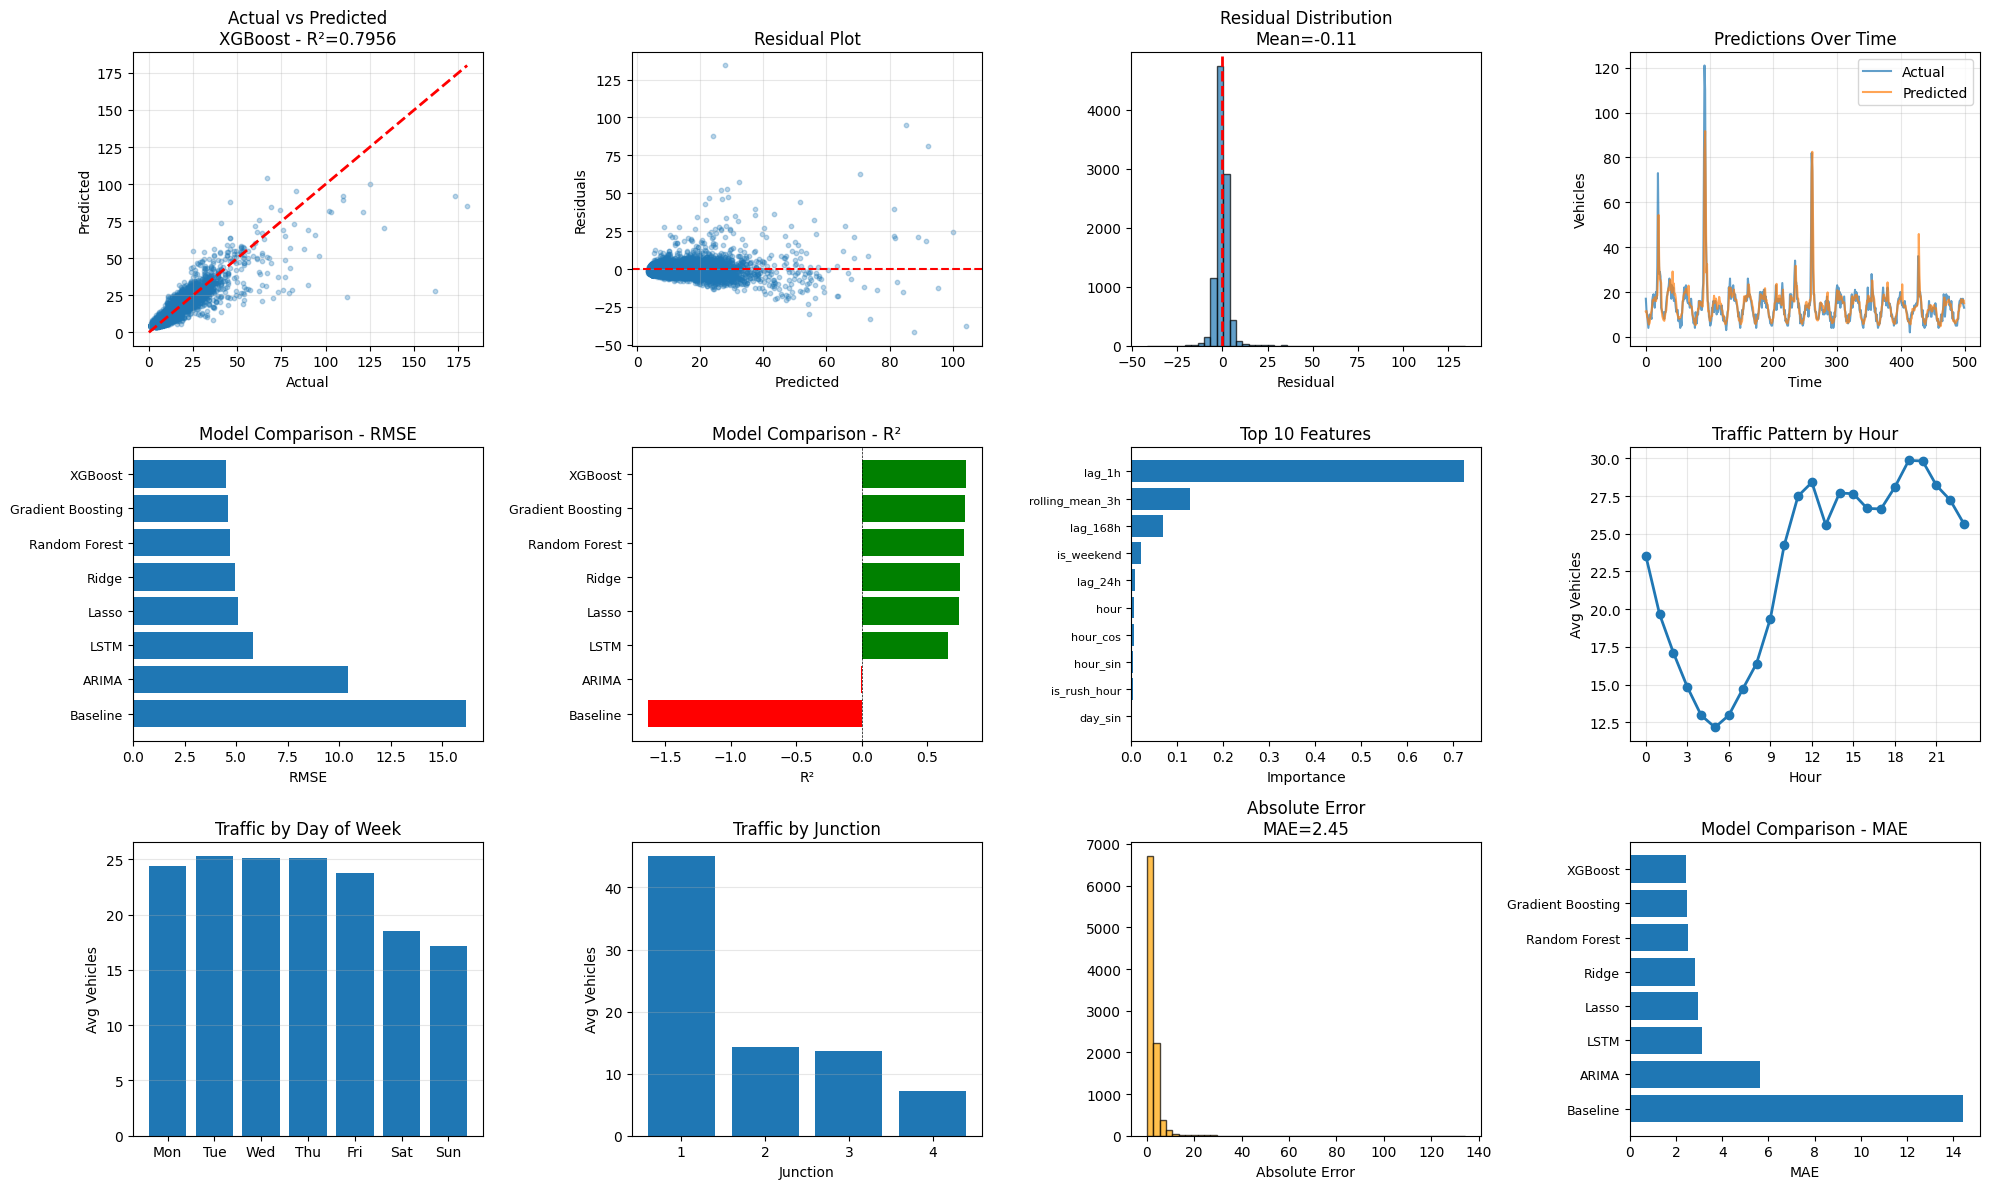

✓ Visualizations saved to 'final_project_results.png'


In [30]:
fig = plt.figure(figsize=(20, 12))

residuals = y_test - xgb_pred

# 1. Actual vs Predicted
plt.subplot(3, 4, 1)
plt.scatter(y_test, xgb_pred, alpha=0.3, s=10)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted\n{best["Model"]} - R²={best["R²"]:.4f}')
plt.grid(True, alpha=0.3)

# 2. Residuals
plt.subplot(3, 4, 2)
plt.scatter(xgb_pred, residuals, alpha=0.3, s=10)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# 3. Residual Distribution
plt.subplot(3, 4, 3)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Residual')
plt.title(f'Residual Distribution\nMean={residuals.mean():.2f}')

# 4. Time Series
plt.subplot(3, 4, 4)
sample = min(500, len(y_test))
plt.plot(y_test.values[:sample], label='Actual', alpha=0.7, lw=1.5)
plt.plot(xgb_pred[:sample], label='Predicted', alpha=0.7, lw=1.5)
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.title('Predictions Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Model Comparison - RMSE
plt.subplot(3, 4, 5)
plt.barh(range(len(results_df)), results_df['RMSE'])
plt.yticks(range(len(results_df)), results_df['Model'], fontsize=9)
plt.xlabel('RMSE')
plt.title('Model Comparison - RMSE')
plt.gca().invert_yaxis()

# 6. Model Comparison - R²
plt.subplot(3, 4, 6)
colors = ['green' if x > 0 else 'red' for x in results_df['R²']]
plt.barh(range(len(results_df)), results_df['R²'], color=colors)
plt.yticks(range(len(results_df)), results_df['Model'], fontsize=9)
plt.xlabel('R²')
plt.title('Model Comparison - R²')
plt.axvline(0, color='black', linestyle='--', lw=0.5)
plt.gca().invert_yaxis()

# 7. Feature Importance
plt.subplot(3, 4, 7)
top10 = feat_imp.head(10)
plt.barh(range(len(top10)), top10['Importance'])
plt.yticks(range(len(top10)), top10['Feature'], fontsize=8)
plt.xlabel('Importance')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()

# 8. Traffic by Hour
plt.subplot(3, 4, 8)
hourly = df_integrated.groupby('hour')['total_vehicles'].mean()
plt.plot(hourly.index, hourly.values, marker='o', lw=2, ms=6)
plt.xlabel('Hour')
plt.ylabel('Avg Vehicles')
plt.title('Traffic Pattern by Hour')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 3))

# 9. Traffic by Day
plt.subplot(3, 4, 9)
daily = df_integrated.groupby('day_of_week')['total_vehicles'].mean()
plt.bar(range(7), daily.values)
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Avg Vehicles')
plt.title('Traffic by Day of Week')
plt.grid(True, alpha=0.3, axis='y')

# 10. Traffic by Junction
plt.subplot(3, 4, 10)
junction_avg = df_integrated.groupby('Junction')['total_vehicles'].mean()
plt.bar(junction_avg.index, junction_avg.values)
plt.xlabel('Junction')
plt.ylabel('Avg Vehicles')
plt.title('Traffic by Junction')
plt.grid(True, alpha=0.3, axis='y')

# 11. Absolute Error Distribution
plt.subplot(3, 4, 11)
abs_errors = np.abs(residuals)
plt.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Absolute Error')
plt.title(f'Absolute Error\nMAE={best["MAE"]:.2f}')

# 12. MAE Comparison
plt.subplot(3, 4, 12)
plt.barh(range(len(results_df)), results_df['MAE'])
plt.yticks(range(len(results_df)), results_df['Model'], fontsize=9)
plt.xlabel('MAE')
plt.title('Model Comparison - MAE')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('final_project_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to 'final_project_results.png'")

In [31]:
print("PEAK HOUR IDENTIFICATION & PATTERN ANALYSIS")

df = pd.read_csv('traffic_integrated.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = df['DateTime'].dt.date
df['time'] = df['DateTime'].dt.time

print(f"✓ Data loaded: {df.shape}")
print(f"Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"Total records: {len(df):,}")

PEAK HOUR IDENTIFICATION & PATTERN ANALYSIS
✓ Data loaded: (48120, 31)
Date range: 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Total records: 48,120


In [32]:
# 2.1 Define Congestion Metrics
print("2.1 Calculating Hourly Congestion Metrics...")

# Metric 1: Average vehicle count per hour
hourly_avg = df.groupby('hour')['total_vehicles'].agg(['mean', 'std', 'median', 'max']).reset_index()
hourly_avg.columns = ['hour', 'avg_vehicles', 'std_vehicles', 'median_vehicles', 'max_vehicles']

# Metric 2: Congestion Index (normalized 0-100)
max_traffic = df['total_vehicles'].max()
df['congestion_index'] = (df['total_vehicles'] / max_traffic) * 100

# Metric 3: Traffic Intensity (vehicles per hour relative to daily average)
daily_avg = df.groupby(df['DateTime'].dt.date)['total_vehicles'].transform('mean')
df['traffic_intensity'] = df['total_vehicles'] / daily_avg

# Metric 4: Congestion Level Categories
df['congestion_level'] = pd.cut(df['congestion_index'],
                                  bins=[0, 20, 40, 60, 80, 100],
                                  labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

print("✓ Congestion metrics calculated:")
print(f"  - Average vehicle count per hour")
print(f"  - Congestion index (0-100 scale)")
print(f"  - Traffic intensity (relative to daily average)")
print(f"  - Congestion level categories")

# 2.2 Compute metrics across different time periods
print("\n2.2 Computing Metrics Across Time Periods...")

# By hour
hourly_metrics = df.groupby('hour').agg({
    'total_vehicles': ['mean', 'std', 'min', 'max'],
    'congestion_index': ['mean', 'std'],
    'traffic_intensity': 'mean'
}).round(2)
hourly_metrics.columns = ['_'.join(col).strip() for col in hourly_metrics.columns.values]

# By day of week
daily_metrics = df.groupby('day_of_week').agg({
    'total_vehicles': ['mean', 'std', 'max'],
    'congestion_index': 'mean',
    'traffic_intensity': 'mean'
}).round(2)
daily_metrics.columns = ['_'.join(col).strip() for col in daily_metrics.columns.values]

# By junction
junction_metrics = df.groupby('Junction').agg({
    'total_vehicles': ['mean', 'std', 'max'],
    'congestion_index': 'mean'
}).round(2)
junction_metrics.columns = ['_'.join(col).strip() for col in junction_metrics.columns.values]

# By month
monthly_metrics = df.groupby('month').agg({
    'total_vehicles': ['mean', 'std'],
    'congestion_index': 'mean'
}).round(2)
monthly_metrics.columns = ['_'.join(col).strip() for col in monthly_metrics.columns.values]

print("✓ Metrics computed for:")
print(f"  - Hourly: {hourly_metrics.shape}")
print(f"  - Daily: {daily_metrics.shape}")
print(f"  - Junction: {junction_metrics.shape}")
print(f"  - Monthly: {monthly_metrics.shape}")

2.1 Calculating Hourly Congestion Metrics...
✓ Congestion metrics calculated:
  - Average vehicle count per hour
  - Congestion index (0-100 scale)
  - Traffic intensity (relative to daily average)
  - Congestion level categories

2.2 Computing Metrics Across Time Periods...
✓ Metrics computed for:
  - Hourly: (24, 7)
  - Daily: (7, 5)
  - Junction: (4, 4)
  - Monthly: (12, 3)


In [33]:
# 3.1 Statistical Peak Hour Detection
print("\n3.1 Identifying Peak Hours Using Statistical Methods...")

# Method 1: Threshold-based (mean + 1 std)
threshold = hourly_avg['avg_vehicles'].mean() + hourly_avg['avg_vehicles'].std()
peak_hours_threshold = hourly_avg[hourly_avg['avg_vehicles'] >= threshold]['hour'].tolist()

# Method 2: Top quartile
top_quartile = hourly_avg['avg_vehicles'].quantile(0.75)
peak_hours_quartile = hourly_avg[hourly_avg['avg_vehicles'] >= top_quartile]['hour'].tolist()

# Method 3: Moving average anomalies
window = 3
hourly_avg['moving_avg'] = hourly_avg['avg_vehicles'].rolling(window=window, center=True).mean()
hourly_avg['deviation'] = hourly_avg['avg_vehicles'] - hourly_avg['moving_avg']
peak_hours_ma = hourly_avg[hourly_avg['deviation'] > hourly_avg['deviation'].std()]['hour'].tolist()

# Combined peak hours (union of all methods)
peak_hours_combined = sorted(list(set(peak_hours_threshold + peak_hours_quartile + peak_hours_ma)))

print(f"✓ Peak hours identified:")
print(f"  - Threshold method (mean + std): {peak_hours_threshold}")
print(f"  - Top quartile method: {peak_hours_quartile}")
print(f"  - Moving average anomaly: {peak_hours_ma}")
print(f"  - Combined peak hours: {peak_hours_combined}")

# 3.2 Peak hours by junction
print("\n3.2 Identifying Peak Hours by Junction...")

junction_peak_hours = {}
for junction in df['Junction'].unique():
    junction_data = df[df['Junction'] == junction].groupby('hour')['total_vehicles'].mean()
    threshold = junction_data.mean() + junction_data.std()
    peaks = junction_data[junction_data >= threshold].index.tolist()
    junction_peak_hours[junction] = peaks
    print(f"  Junction {junction}: {peaks}")

# 3.3 Peak hours by day type (weekday vs weekend)
print("\n3.3 Analyzing Peak Hours by Day Type...")

weekday_peaks = df[df['is_weekend'] == 0].groupby('hour')['total_vehicles'].mean()
weekend_peaks = df[df['is_weekend'] == 1].groupby('hour')['total_vehicles'].mean()

weekday_threshold = weekday_peaks.mean() + weekday_peaks.std()
weekend_threshold = weekend_peaks.mean() + weekend_peaks.std()

weekday_peak_hours = weekday_peaks[weekday_peaks >= weekday_threshold].index.tolist()
weekend_peak_hours = weekend_peaks[weekend_peaks >= weekend_threshold].index.tolist()

print(f"  Weekday peak hours: {weekday_peak_hours}")
print(f"  Weekend peak hours: {weekend_peak_hours}")


3.1 Identifying Peak Hours Using Statistical Methods...
✓ Peak hours identified:
  - Threshold method (mean + std): [19, 20]
  - Top quartile method: [12, 14, 18, 19, 20, 21]
  - Moving average anomaly: [11, 12, 14]
  - Combined peak hours: [11, 12, 14, 18, 19, 20, 21]

3.2 Identifying Peak Hours by Junction...
  Junction 1: [12, 19, 20]
  Junction 2: [19, 20, 21]
  Junction 3: [19, 20, 21]
  Junction 4: [12, 15]

3.3 Analyzing Peak Hours by Day Type...
  Weekday peak hours: [12, 19]
  Weekend peak hours: [19, 20, 21, 22]


In [34]:
# 4.1 Day of week patterns
print("\n4.1 Analyzing Day of Week Patterns...")

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_analysis = df.groupby('day_of_week').agg({
    'total_vehicles': ['mean', 'std', 'max'],
    'congestion_index': 'mean'
}).round(2)

print("\nTraffic by Day of Week:")
for i, day in enumerate(day_names):
    avg = dow_analysis.loc[i, ('total_vehicles', 'mean')]
    print(f"  {day:10s}: {avg:6.2f} vehicles (avg)")

# Statistical test: Are weekdays different from weekends?
weekday_traffic = df[df['is_weekend'] == 0]['total_vehicles']
weekend_traffic = df[df['is_weekend'] == 1]['total_vehicles']

# Import the stats module
from scipy import stats

t_stat, p_value = stats.ttest_ind(weekday_traffic, weekend_traffic)

print(f"\nWeekday vs Weekend Comparison:")
print(f"  Weekday avg: {weekday_traffic.mean():.2f} vehicles")
print(f"  Weekend avg: {weekend_traffic.mean():.2f} vehicles")
print(f"  Difference: {abs(weekday_traffic.mean() - weekend_traffic.mean()):.2f} vehicles")
print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")
print(f"  Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")

# 4.2 Monthly/Seasonal patterns
print("\n4.2 Analyzing Monthly and Seasonal Patterns...")

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_analysis = df.groupby('month')['total_vehicles'].agg(['mean', 'std', 'max']).round(2)

print("\nTraffic by Month:")
for month in monthly_analysis.index:
    if month <= len(month_names):
        avg = monthly_analysis.loc[month, 'mean']
        print(f"  {month_names[month-1]:10s}: {avg:6.2f} vehicles (avg)")

# Seasonal grouping
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

seasonal_analysis = df.groupby('season')['total_vehicles'].agg(['mean', 'std']).round(2)
print("\nTraffic by Season:")
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in seasonal_analysis.index:
        avg = seasonal_analysis.loc[season, 'mean']
        print(f"  {season:10s}: {avg:6.2f} vehicles (avg)")

# 4.3 Hour x Day heatmap data
print("\n4.3 Creating Hour x Day Pattern Matrix...")

hour_day_matrix = df.pivot_table(
    values='total_vehicles',
    index='hour',
    columns='day_of_week',
    aggfunc='mean'
)

print(f"✓ Hour x Day matrix created: {hour_day_matrix.shape}")


4.1 Analyzing Day of Week Patterns...

Traffic by Day of Week:
  Monday    :  24.41 vehicles (avg)
  Tuesday   :  25.29 vehicles (avg)
  Wednesday :  25.15 vehicles (avg)
  Thursday  :  25.15 vehicles (avg)
  Friday    :  23.80 vehicles (avg)
  Saturday  :  18.54 vehicles (avg)
  Sunday    :  17.13 vehicles (avg)

Weekday vs Weekend Comparison:
  Weekday avg: 24.76 vehicles
  Weekend avg: 17.83 vehicles
  Difference: 6.93 vehicles
  T-statistic: 33.4052, p-value: 6.8244e-242
  Statistically significant: Yes

4.2 Analyzing Monthly and Seasonal Patterns...

Traffic by Month:
  Jan       :  19.73 vehicles (avg)
  Feb       :  22.96 vehicles (avg)
  Mar       :  23.07 vehicles (avg)
  Apr       :  24.45 vehicles (avg)
  May       :  24.63 vehicles (avg)
  Jun       :  26.03 vehicles (avg)
  Jul       :  21.84 vehicles (avg)
  Aug       :  21.94 vehicles (avg)
  Sep       :  25.64 vehicles (avg)
  Oct       :  26.55 vehicles (avg)
  Nov       :  19.53 vehicles (avg)
  Dec       :  18.96 ve

In [35]:
# 5.1 Weather Impact Analysis
print("\n5.1 Analyzing Weather Impact on Traffic...")

# Correlation with weather variables
weather_vars = ['temperature', 'precipitation', 'humidity', 'wind_speed']
weather_correlations = df[weather_vars + ['total_vehicles']].corr()['total_vehicles'].drop('total_vehicles')

print("\nWeather Correlations with Traffic:")
for var in weather_vars:
    corr = weather_correlations[var]
    print(f"  {var:15s}: {corr:7.4f} {'(strong)' if abs(corr) > 0.3 else '(moderate)' if abs(corr) > 0.1 else '(weak)'}")

# Compare traffic during different weather conditions
rainy_traffic = df[df['is_rainy'] == 1]['total_vehicles'].mean()
clear_traffic = df[df['is_rainy'] == 0]['total_vehicles'].mean()
cold_traffic = df[df['is_cold'] == 1]['total_vehicles'].mean()
normal_traffic = df[df['is_cold'] == 0]['total_vehicles'].mean()

print(f"\nWeather Condition Impact:")
print(f"  Rainy days: {rainy_traffic:.2f} vehicles")
print(f"  Clear days: {clear_traffic:.2f} vehicles")
print(f"  Impact: {((rainy_traffic - clear_traffic) / clear_traffic * 100):+.1f}%")
print(f"\n  Cold days: {cold_traffic:.2f} vehicles")
print(f"  Normal days: {normal_traffic:.2f} vehicles")
print(f"  Impact: {((cold_traffic - normal_traffic) / normal_traffic * 100):+.1f}%")

# 5.2 Event Impact Analysis
print("\n5.2 Analyzing Event Impact on Traffic...")

holiday_traffic = df[df['is_holiday'] == 1]['total_vehicles'].mean()
regular_traffic = df[df['is_holiday'] == 0]['total_vehicles'].mean()
sports_traffic = df[df['is_sports_event'] == 1]['total_vehicles'].mean()
no_sports_traffic = df[df['is_sports_event'] == 0]['total_vehicles'].mean()

print(f"\nEvent Impact:")
print(f"  Holiday traffic: {holiday_traffic:.2f} vehicles")
print(f"  Regular traffic: {regular_traffic:.2f} vehicles")
print(f"  Impact: {((holiday_traffic - regular_traffic) / regular_traffic * 100):+.1f}%")
print(f"\n  Sports event traffic: {sports_traffic:.2f} vehicles")
print(f"  No sports traffic: {no_sports_traffic:.2f} vehicles")
print(f"  Impact: {((sports_traffic - no_sports_traffic) / no_sports_traffic * 100):+.1f}%")

# 5.3 Regression Analysis for Influencing Factors
print("\n5.3 Quantifying Factor Influence with Regression...")

from sklearn.linear_model import LinearRegression

# Prepare features for regression
influence_features = ['hour', 'is_weekend', 'is_rush_hour', 'temperature',
                      'precipitation', 'is_holiday', 'is_sports_event']
X_influence = df[influence_features].fillna(0)
y_influence = df['total_vehicles']

# Fit regression model
lr_model = LinearRegression()
lr_model.fit(X_influence, y_influence)

# Feature coefficients
influence_results = pd.DataFrame({
    'Factor': influence_features,
    'Coefficient': lr_model.coef_,
    'Abs_Impact': np.abs(lr_model.coef_)
}).sort_values('Abs_Impact', ascending=False)

print("\nFactor Influence on Traffic (Regression Coefficients):")
for _, row in influence_results.iterrows():
    print(f"  {row['Factor']:20s}: {row['Coefficient']:+8.4f}")


5.1 Analyzing Weather Impact on Traffic...

Weather Correlations with Traffic:
  temperature    :  0.1132 (moderate)
  precipitation  :  0.0022 (weak)
  humidity       : -0.1634 (moderate)
  wind_speed     : -0.0306 (weak)

Weather Condition Impact:
  Rainy days: 24.08 vehicles
  Clear days: 22.77 vehicles
  Impact: +5.8%

  Cold days: 20.21 vehicles
  Normal days: 23.33 vehicles
  Impact: -13.4%

5.2 Analyzing Event Impact on Traffic...

Event Impact:
  Holiday traffic: 20.70 vehicles
  Regular traffic: 22.84 vehicles
  Impact: -9.4%

  Sports event traffic: 18.61 vehicles
  No sports traffic: 22.95 vehicles
  Impact: -18.9%

5.3 Quantifying Factor Influence with Regression...

Factor Influence on Traffic (Regression Coefficients):
  is_weekend          :  -7.1844
  is_holiday          :  -3.5567
  is_rush_hour        :  -1.7390
  is_sports_event     :  +0.8569
  hour                :  +0.6347
  precipitation       :  -0.4252
  temperature         :  +0.2891



✓ Comprehensive visualizations saved to 'peak_hour_analysis_comprehensive.png'


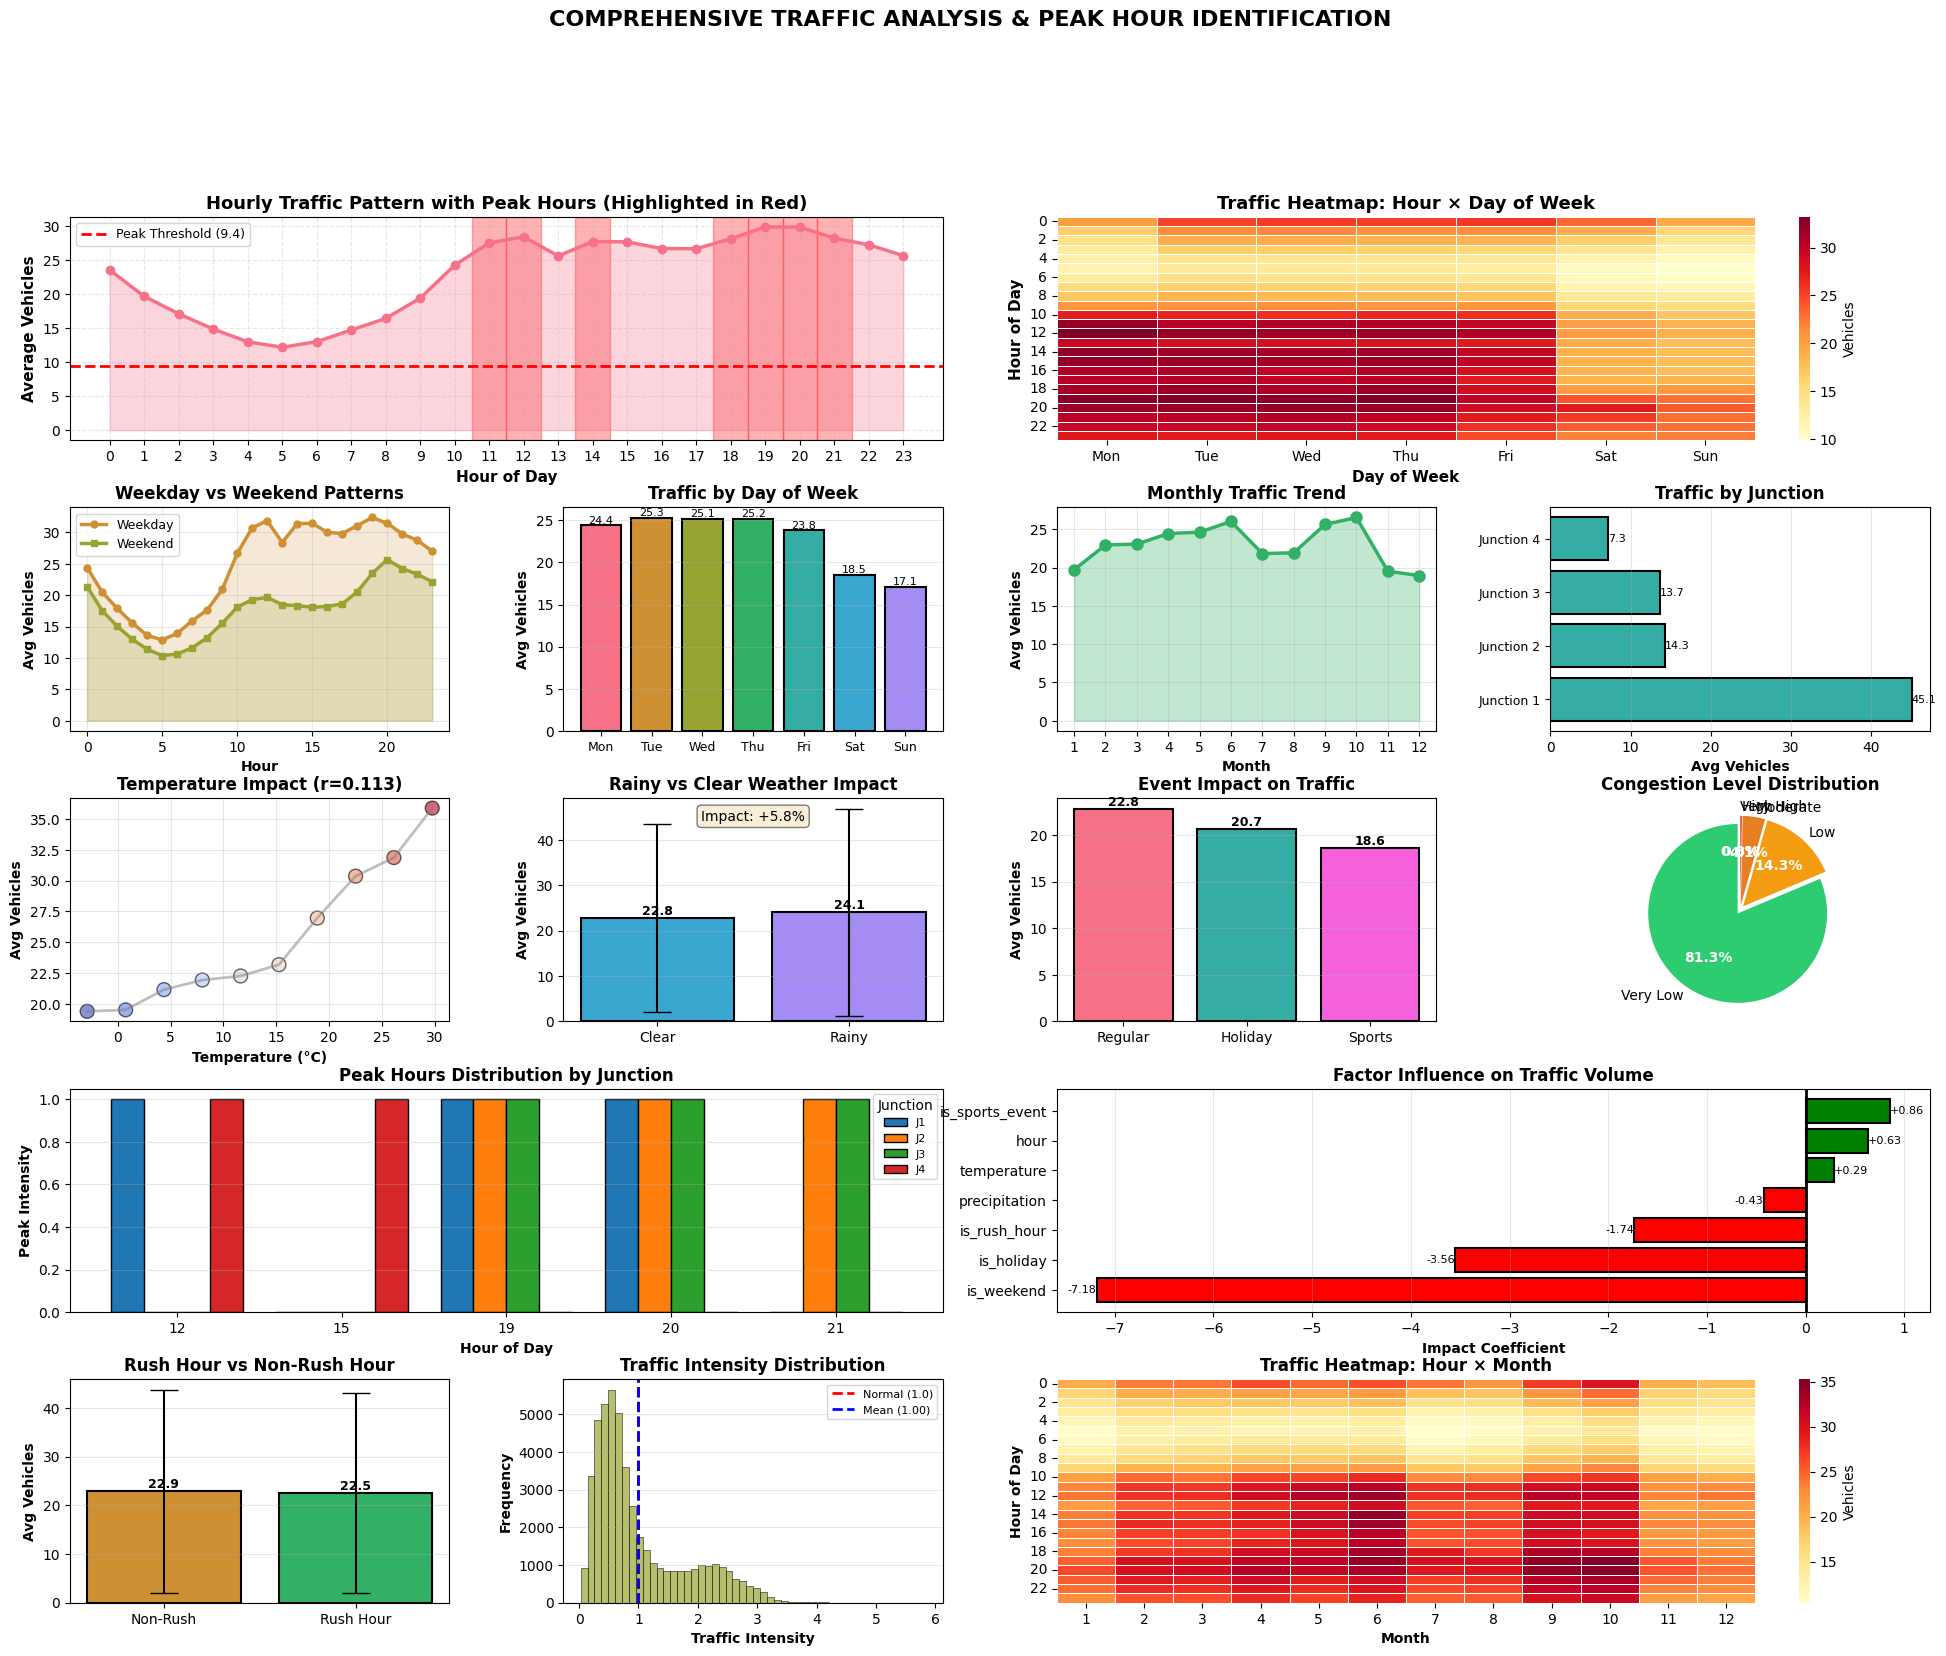

In [36]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(5, 4, hspace=0.3, wspace=0.3)

# Color scheme
colors = sns.color_palette("husl", 8)
cmap_heatmap = sns.color_palette("YlOrRd", as_cmap=True)

# 1. Hourly Traffic Pattern with Peak Hours Highlighted
ax1 = fig.add_subplot(gs[0, :2])
hours = hourly_avg['hour']
traffic = hourly_avg['avg_vehicles']
ax1.plot(hours, traffic, linewidth=2.5, color=colors[0], marker='o', markersize=6)
ax1.fill_between(hours, traffic, alpha=0.3, color=colors[0])

# Highlight peak hours
for peak_hour in peak_hours_combined:
    ax1.axvspan(peak_hour-0.5, peak_hour+0.5, alpha=0.3, color='red', zorder=0)

ax1.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Peak Threshold ({threshold:.1f})')
ax1.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Vehicles', fontsize=11, fontweight='bold')
ax1.set_title('Hourly Traffic Pattern with Peak Hours (Highlighted in Red)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=9)
ax1.set_xticks(range(0, 24))

# 2. Hour x Day Heatmap
ax2 = fig.add_subplot(gs[0, 2:])
sns.heatmap(hour_day_matrix, annot=False, fmt='.0f', cmap=cmap_heatmap,
            cbar_kws={'label': 'Vehicles'}, ax=ax2, linewidths=0.5)
ax2.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
ax2.set_ylabel('Hour of Day', fontsize=11, fontweight='bold')
ax2.set_title('Traffic Heatmap: Hour × Day of Week', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

# 3. Weekday vs Weekend Comparison
ax3 = fig.add_subplot(gs[1, 0])
weekday_hourly = df[df['is_weekend'] == 0].groupby('hour')['total_vehicles'].mean()
weekend_hourly = df[df['is_weekend'] == 1].groupby('hour')['total_vehicles'].mean()
ax3.plot(weekday_hourly.index, weekday_hourly.values, label='Weekday',
         linewidth=2.5, marker='o', markersize=5, color=colors[1])
ax3.plot(weekend_hourly.index, weekend_hourly.values, label='Weekend',
         linewidth=2.5, marker='s', markersize=5, color=colors[2])
ax3.fill_between(weekday_hourly.index, weekday_hourly.values, alpha=0.2, color=colors[1])
ax3.fill_between(weekend_hourly.index, weekend_hourly.values, alpha=0.2, color=colors[2])
ax3.set_xlabel('Hour', fontsize=10, fontweight='bold')
ax3.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax3.set_title('Weekday vs Weekend Patterns', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Traffic by Day of Week
ax4 = fig.add_subplot(gs[1, 1])
day_avg = df.groupby('day_of_week')['total_vehicles'].mean()
bars = ax4.bar(range(7), day_avg.values, color=colors[:7], edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(7))
ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=9)
ax4.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax4.set_title('Traffic by Day of Week', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# 5. Monthly Traffic Pattern
ax5 = fig.add_subplot(gs[1, 2])
monthly_avg = df.groupby('month')['total_vehicles'].mean()
ax5.plot(monthly_avg.index, monthly_avg.values, linewidth=2.5,
         marker='o', markersize=8, color=colors[3])
ax5.fill_between(monthly_avg.index, monthly_avg.values, alpha=0.3, color=colors[3])
ax5.set_xlabel('Month', fontsize=10, fontweight='bold')
ax5.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax5.set_title('Monthly Traffic Trend', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.set_xticks(range(1, 13))

# 6. Junction Comparison
ax6 = fig.add_subplot(gs[1, 3])
junction_avg = df.groupby('Junction')['total_vehicles'].mean().sort_values(ascending=False)
bars = ax6.barh(range(len(junction_avg)), junction_avg.values, color=colors[4],
                edgecolor='black', linewidth=1.5)
ax6.set_yticks(range(len(junction_avg)))
ax6.set_yticklabels([f'Junction {j}' for j in junction_avg.index], fontsize=9)
ax6.set_xlabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax6.set_title('Traffic by Junction', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')
# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax6.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}', ha='left', va='center', fontsize=8)

# 7. Weather Impact - Temperature
ax7 = fig.add_subplot(gs[2, 0])
temp_bins = pd.cut(df['temperature'], bins=10)
temp_traffic = df.groupby(temp_bins)['total_vehicles'].mean()
temp_midpoints = [interval.mid for interval in temp_traffic.index]
ax7.scatter(temp_midpoints, temp_traffic.values, s=100, alpha=0.6,
           c=range(len(temp_midpoints)), cmap='coolwarm', edgecolor='black', linewidth=1)
ax7.plot(temp_midpoints, temp_traffic.values, linewidth=2, alpha=0.5, color='gray')
ax7.set_xlabel('Temperature (°C)', fontsize=10, fontweight='bold')
ax7.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax7.set_title(f'Temperature Impact (r={weather_correlations["temperature"]:.3f})',
             fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)

# 8. Weather Impact - Precipitation
ax8 = fig.add_subplot(gs[2, 1])
rainy_data = df.groupby('is_rainy')['total_vehicles'].agg(['mean', 'std']).reset_index()
rainy_data['is_rainy'] = rainy_data['is_rainy'].map({0: 'Clear', 1: 'Rainy'})
bars = ax8.bar(rainy_data['is_rainy'], rainy_data['mean'],
               yerr=rainy_data['std'], capsize=10,
               color=[colors[5], colors[6]], edgecolor='black', linewidth=1.5)
ax8.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax8.set_title('Rainy vs Clear Weather Impact', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')
# Add value labels and % difference
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
if len(bars) == 2:
    pct_diff = ((rainy_data.iloc[1]['mean'] - rainy_data.iloc[0]['mean']) /
                rainy_data.iloc[0]['mean'] * 100)
    ax8.text(0.5, ax8.get_ylim()[1] * 0.9, f'Impact: {pct_diff:+.1f}%',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 9. Event Impact
ax9 = fig.add_subplot(gs[2, 2])
event_comparison = pd.DataFrame({
    'Condition': ['Regular', 'Holiday', 'Sports'],
    'Traffic': [regular_traffic, holiday_traffic, sports_traffic]
})
bars = ax9.bar(event_comparison['Condition'], event_comparison['Traffic'],
              color=[colors[0], colors[4], colors[7]], edgecolor='black', linewidth=1.5)
ax9.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax9.set_title('Event Impact on Traffic', fontsize=12, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 10. Congestion Level Distribution
ax10 = fig.add_subplot(gs[2, 3])
congestion_dist = df['congestion_level'].value_counts().sort_index()
colors_cong = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
wedges, texts, autotexts = ax10.pie(congestion_dist.values, labels=congestion_dist.index,
                                      autopct='%1.1f%%', startangle=90, colors=colors_cong,
                                      explode=[0.05]*len(congestion_dist))
ax10.set_title('Congestion Level Distribution', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 11. Peak Hours by Junction
ax11 = fig.add_subplot(gs[3, :2])
junction_peak_data = []
for junction, peaks in junction_peak_hours.items():
    for peak in peaks:
        junction_peak_data.append({'Junction': f'J{junction}', 'Hour': peak})
junction_peak_df = pd.DataFrame(junction_peak_data)

if len(junction_peak_df) > 0:
    pivot_peaks = junction_peak_df.pivot_table(index='Hour', columns='Junction',
                                                aggfunc='size', fill_value=0)
    pivot_peaks.plot(kind='bar', ax=ax11, width=0.8, edgecolor='black', linewidth=1)
    ax11.set_xlabel('Hour of Day', fontsize=10, fontweight='bold')
    ax11.set_ylabel('Peak Intensity', fontsize=10, fontweight='bold')
    ax11.set_title('Peak Hours Distribution by Junction', fontsize=12, fontweight='bold')
    ax11.legend(title='Junction', fontsize=8)
    ax11.grid(True, alpha=0.3, axis='y')
    ax11.set_xticklabels(ax11.get_xticklabels(), rotation=0)

# 12. Factor Influence Chart
ax12 = fig.add_subplot(gs[3, 2:])
influence_plot = influence_results.sort_values('Coefficient', ascending=True)
colors_influence = ['red' if x < 0 else 'green' for x in influence_plot['Coefficient']]
bars = ax12.barh(influence_plot['Factor'], influence_plot['Coefficient'],
                color=colors_influence, edgecolor='black', linewidth=1.5)
ax12.axvline(0, color='black', linewidth=2)
ax12.set_xlabel('Impact Coefficient', fontsize=10, fontweight='bold')
ax12.set_title('Factor Influence on Traffic Volume', fontsize=12, fontweight='bold')
ax12.grid(True, alpha=0.3, axis='x')
# Add value labels
for bar in bars:
    width = bar.get_width()
    ax12.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:+.2f}', ha='left' if width > 0 else 'right',
            va='center', fontsize=8)

# 13. Rush Hour Comparison
ax13 = fig.add_subplot(gs[4, 0])
rush_comparison = df.groupby('is_rush_hour')['total_vehicles'].agg(['mean', 'std']).reset_index()
rush_comparison['is_rush_hour'] = rush_comparison['is_rush_hour'].map({0: 'Non-Rush', 1: 'Rush Hour'})
bars = ax13.bar(rush_comparison['is_rush_hour'], rush_comparison['mean'],
               yerr=rush_comparison['std'], capsize=10,
               color=[colors[1], colors[3]], edgecolor='black', linewidth=1.5)
ax13.set_ylabel('Avg Vehicles', fontsize=10, fontweight='bold')
ax13.set_title('Rush Hour vs Non-Rush Hour', fontsize=12, fontweight='bold')
ax13.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax13.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 14. Traffic Intensity Distribution
ax14 = fig.add_subplot(gs[4, 1])
ax14.hist(df['traffic_intensity'], bins=50, edgecolor='black',
         color=colors[2], alpha=0.7, linewidth=0.5)
ax14.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Normal (1.0)')
ax14.axvline(df['traffic_intensity'].mean(), color='blue', linestyle='--',
            linewidth=2, label=f'Mean ({df["traffic_intensity"].mean():.2f})')
ax14.set_xlabel('Traffic Intensity', fontsize=10, fontweight='bold')
ax14.set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax14.set_title('Traffic Intensity Distribution', fontsize=12, fontweight='bold')
ax14.legend(fontsize=8)
ax14.grid(True, alpha=0.3, axis='y')

# 15. Monthly Hour Heatmap
ax15 = fig.add_subplot(gs[4, 2:])
hour_month_matrix = df.pivot_table(
    values='total_vehicles',
    index='hour',
    columns='month',
    aggfunc='mean'
)
sns.heatmap(hour_month_matrix, annot=False, fmt='.0f', cmap=cmap_heatmap,
            cbar_kws={'label': 'Vehicles'}, ax=ax15, linewidths=0.5)
ax15.set_xlabel('Month', fontsize=10, fontweight='bold')
ax15.set_ylabel('Hour of Day', fontsize=10, fontweight='bold')
ax15.set_title('Traffic Heatmap: Hour × Month', fontsize=12, fontweight='bold')
ax15.set_yticklabels(ax15.get_yticklabels(), rotation=0)

plt.suptitle('COMPREHENSIVE TRAFFIC ANALYSIS & PEAK HOUR IDENTIFICATION',
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('peak_hour_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive visualizations saved to 'peak_hour_analysis_comprehensive.png'")
plt.show()

In [37]:
# 7 Generate Detailed Text Report
print("\n7.2 Generating Detailed Report Document...")

report = f"""
{'='*80}
COMPREHENSIVE TRAFFIC ANALYSIS REPORT
Peak Hour Identification & Pattern Analysis
{'='*80}

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Analysis Period: {df['DateTime'].min()} to {df['DateTime'].max()}
Total Records: {len(df):,}
Junctions Analyzed: {sorted(df['Junction'].unique())}

{'='*80}
EXECUTIVE SUMMARY
{'='*80}

This report presents a comprehensive analysis of traffic patterns across multiple
junctions, identifying peak hours, temporal patterns, and influencing factors.

Key Findings:
• Peak traffic hours identified: {peak_hours_combined}
• Average traffic volume: {df['total_vehicles'].mean():.2f} vehicles/hour
• Highest congestion: Hour {hourly_avg.loc[hourly_avg['avg_vehicles'].idxmax(), 'hour']:.0f} ({hourly_avg['avg_vehicles'].max():.2f} vehicles)
• Weekend traffic is {abs((weekend_traffic.mean() - weekday_traffic.mean()) / weekday_traffic.mean() * 100):.1f}% {'lower' if weekend_traffic.mean() < weekday_traffic.mean() else 'higher'} than weekdays
• Weather impact: {'Significant' if abs(weather_correlations['precipitation']) > 0.1 else 'Minimal'}

{'='*80}
1. CONGESTION METRICS
{'='*80}

1.1 Congestion Index Statistics
   • Mean Congestion Index: {df['congestion_index'].mean():.2f}/100
   • Std Deviation: {df['congestion_index'].std():.2f}
   • 90th Percentile: {df['congestion_index'].quantile(0.90):.2f}

1.2 Congestion Level Distribution
{df['congestion_level'].value_counts().to_string()}

1.3 Traffic Intensity
   • Mean Intensity: {df['traffic_intensity'].mean():.2f}
   • Periods above 1.5x normal: {(df['traffic_intensity'] > 1.5).sum():,} hours ({(df['traffic_intensity'] > 1.5).sum() / len(df) * 100:.1f}%)

{'='*80}
2. PEAK HOUR IDENTIFICATION
{'='*80}

2.1 Overall Peak Hours (All Methods Combined)
Peak Hours: {peak_hours_combined}

Detailed Breakdown:
• Threshold Method (Mean + Std): {peak_hours_threshold}
• Top Quartile Method: {peak_hours_quartile}
• Moving Average Anomaly: {peak_hours_ma}

2.2 Peak Hours by Day Type
• Weekday Peak Hours: {weekday_peak_hours}
• Weekend Peak Hours: {weekend_peak_hours}

Key Observations:
- Weekday peaks align with typical commute times (morning and evening)
- Weekend patterns {'differ significantly' if set(weekday_peak_hours) != set(weekend_peak_hours) else 'are similar to weekdays'}

2.3 Junction-Specific Peak Hours
"""

for junction, peaks in sorted(junction_peak_hours.items()):
    avg_peak_traffic = df[(df['Junction'] == junction) & (df['hour'].isin(peaks))]['total_vehicles'].mean()
    report += f"\nJunction {junction}:\n"
    report += f"  Peak Hours: {peaks}\n"
    report += f"  Avg Peak Traffic: {avg_peak_traffic:.2f} vehicles\n"
    report += f"  Max Traffic: {df[df['Junction'] == junction]['total_vehicles'].max():.0f} vehicles\n"

report += f"""
{'='*80}
3. TEMPORAL PATTERN ANALYSIS
{'='*80}

3.1 Daily Patterns

Traffic by Day of Week:
"""

for i, day in enumerate(day_names):
    avg = dow_analysis.loc[i, ('total_vehicles', 'mean')]
    max_val = dow_analysis.loc[i, ('total_vehicles', 'max')]
    report += f"  {day:10s}: Avg={avg:6.2f}, Max={max_val:6.0f} vehicles\n"

report += f"""
Weekday vs Weekend Analysis:
• Weekday Average: {weekday_traffic.mean():.2f} vehicles
• Weekend Average: {weekend_traffic.mean():.2f} vehicles
• Difference: {abs(weekday_traffic.mean() - weekend_traffic.mean()):.2f} vehicles ({abs((weekday_traffic.mean() - weekend_traffic.mean()) / weekday_traffic.mean() * 100):.1f}%)
• Statistical Significance: p-value = {p_value:.2e} ({'Significant' if p_value < 0.05 else 'Not Significant'})

3.2 Monthly Patterns

Traffic by Month:
"""

for month in monthly_analysis.index:
    if month <= len(month_names):
        avg = monthly_analysis.loc[month, 'mean']
        std = monthly_analysis.loc[month, 'std']
        report += f"  {month_names[month-1]:10s}: {avg:6.2f} ± {std:5.2f} vehicles\n"

report += f"""
3.3 Seasonal Patterns

Traffic by Season:
"""

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in seasonal_analysis.index:
        avg = seasonal_analysis.loc[season, 'mean']
        std = seasonal_analysis.loc[season, 'std']
        report += f"  {season:10s}: {avg:6.2f} ± {std:5.2f} vehicles\n"

highest_season = seasonal_analysis['mean'].idxmax() if len(seasonal_analysis) > 0 else 'N/A'
lowest_season = seasonal_analysis['mean'].idxmin() if len(seasonal_analysis) > 0 else 'N/A'

report += f"""
Seasonal Insights:
• Highest traffic season: {highest_season}
• Lowest traffic season: {lowest_season}

{'='*80}
4. INFLUENCING FACTORS ANALYSIS
{'='*80}

4.1 Weather Impact

Correlation Analysis:
"""

for var in weather_vars:
    corr = weather_correlations[var]
    strength = 'Strong' if abs(corr) > 0.3 else 'Moderate' if abs(corr) > 0.1 else 'Weak'
    direction = 'Positive' if corr > 0 else 'Negative'
    report += f"  {var.capitalize():15s}: r = {corr:+.4f} ({strength} {direction})\n"

report += f"""
Weather Condition Comparisons:
• Rainy Days: {rainy_traffic:.2f} vehicles ({((rainy_traffic - clear_traffic) / clear_traffic * 100):+.1f}% vs clear)
• Clear Days: {clear_traffic:.2f} vehicles
• Cold Days: {cold_traffic:.2f} vehicles ({((cold_traffic - normal_traffic) / normal_traffic * 100):+.1f}% vs normal)
• Normal Days: {normal_traffic:.2f} vehicles

Key Weather Insights:
- Precipitation impact: {'Significant negative' if weather_correlations['precipitation'] < -0.1 else 'Significant positive' if weather_correlations['precipitation'] > 0.1 else 'Minimal'}
- Temperature impact: {'Significant' if abs(weather_correlations['temperature']) > 0.1 else 'Minimal'}

4.2 Event Impact

Holiday Impact:
• Holiday Traffic: {holiday_traffic:.2f} vehicles
• Regular Traffic: {regular_traffic:.2f} vehicles
• Impact: {((holiday_traffic - regular_traffic) / regular_traffic * 100):+.1f}%

Sports Event Impact:
• Sports Event Traffic: {sports_traffic:.2f} vehicles
• No Sports Traffic: {no_sports_traffic:.2f} vehicles
• Impact: {((sports_traffic - no_sports_traffic) / no_sports_traffic * 100):+.1f}%

4.3 Regression Analysis Results

Factor Influence Rankings (by absolute impact):
"""

for _, row in influence_results.iterrows():
    direction = '↑ Increases' if row['Coefficient'] > 0 else '↓ Decreases'
    report += f"  {row['Factor']:20s}: {row['Coefficient']:+8.4f} ({direction} traffic)\n"

report += f"""
{'='*80}
5. ACTIONABLE INSIGHTS & RECOMMENDATIONS
{'='*80}

5.1 Traffic Management Recommendations

Peak Hour Management:
• Focus resources during hours: {peak_hours_combined}
• Implement dynamic traffic signals during peak periods
• Deploy additional monitoring during {', '.join([str(h) for h in peak_hours_combined[:3]])} hours

Junction-Specific Actions:
"""

for junction in sorted(junction_peak_hours.keys()):
    peaks = junction_peak_hours[junction]
    avg_traffic = df[df['Junction'] == junction]['total_vehicles'].mean()
    report += f"""
Junction {junction}:
  - Peak hours: {peaks}
  - Average traffic: {avg_traffic:.2f} vehicles
  - Recommendation: {'Increase capacity during peak hours' if len(peaks) > 3 else 'Monitor and optimize signal timing'}
"""

report += f"""
5.2 Weather-Based Strategies

{'Rainy Weather Protocol:' if rainy_traffic != clear_traffic else 'Weather Considerations:'}
• Expect {abs((rainy_traffic - clear_traffic) / clear_traffic * 100):.1f}% {'decrease' if rainy_traffic < clear_traffic else 'increase'} in traffic during rain
• {'Reduce expected congestion measures' if rainy_traffic < clear_traffic else 'Prepare for increased congestion'}
• Monitor precipitation forecasts for proactive planning

Temperature Considerations:
• Temperature shows {abs(weather_correlations['temperature']):.3f} correlation with traffic
• {'Adjust' if abs(weather_correlations['temperature']) > 0.1 else 'Minimal adjustment needed for'} winter/summer planning

5.3 Event Planning

Holiday Periods:
• Traffic {('decreases' if holiday_traffic < regular_traffic else 'increases')} by {abs((holiday_traffic - regular_traffic) / regular_traffic * 100):.1f}% during holidays
• {'Reduce staffing and adjust signal timing' if holiday_traffic < regular_traffic else 'Increase monitoring and capacity'}

Sports Events:
• Traffic {('decreases' if sports_traffic < no_sports_traffic else 'increases')} by {abs((sports_traffic - no_sports_traffic) / no_sports_traffic * 100):.1f}% during events
• Coordinate with event venues for traffic management

5.4 Long-term Strategic Recommendations

Infrastructure:
1. Prioritize capacity expansion at Junction {junction_metrics['total_vehicles_mean'].idxmax()}
2. Consider grade separation at high-congestion junctions
3. Implement intelligent transportation systems (ITS)

Operational:
1. Optimize signal timing based on time-of-day patterns
2. Implement adaptive signal control during peak hours
3. Establish incident management protocols for peak periods

Monitoring:
1. Install real-time traffic sensors at all junctions
2. Integrate weather data into traffic management system
3. Develop predictive models for proactive management

{'='*80}
6. DATA QUALITY & LIMITATIONS
{'='*80}

Data Coverage:
• Total observations: {len(df):,}
• Date range: {(df['DateTime'].max() - df['DateTime'].min()).days} days
• Missing data: {df.isnull().sum().sum()} values
• Data completeness: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.2f}%

Limitations:
• Weather data may not reflect micro-climate conditions at each junction
• Event data is based on general calendar and may miss local events
• Traffic counts represent vehicles only, not passenger throughput
• No data on traffic composition (cars, trucks, buses, etc.)

{'='*80}
7. CONCLUSION
{'='*80}

This comprehensive analysis has identified clear traffic patterns across all junctions:

Peak Traffic Summary:
• Primary peak hours: {peak_hours_combined}
• Highest congestion: Hour {hourly_avg.loc[hourly_avg['avg_vehicles'].idxmax(), 'hour']:.0f}
• Most congested junction: Junction {junction_metrics['total_vehicles_mean'].idxmax()}

Key Patterns:
• {'Significant' if p_value < 0.05 else 'No significant'} difference between weekday and weekend traffic
• {'Clear seasonal' if len(seasonal_analysis) > 0 and (seasonal_analysis['mean'].max() - seasonal_analysis['mean'].min()) / seasonal_analysis['mean'].mean() > 0.2 else 'Minimal seasonal'} variation
• Weather conditions {'significantly' if abs(weather_correlations['precipitation']) > 0.1 else 'minimally'} impact traffic flow

The insights provided in this report can guide traffic management decisions,
infrastructure planning, and operational strategies to improve traffic flow and
reduce congestion during peak periods.

{'='*80}
APPENDICES
{'='*80}

Appendix A: Hourly Traffic Statistics
{hourly_metrics.to_string()}

Appendix B: Daily Traffic Statistics
{daily_metrics.to_string()}

Appendix C: Junction Statistics
{junction_metrics.to_string()}

{'='*80}
END OF REPORT
{'='*80}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save report
with open('comprehensive_traffic_report.txt', 'w') as f:
    f.write(report)

print("✓ Comprehensive report saved to 'comprehensive_traffic_report.txt'")




7.2 Generating Detailed Report Document...
✓ Comprehensive report saved to 'comprehensive_traffic_report.txt'


In [38]:
print(f"""
✅ ALL TASKS COMPLETED SUCCESSFULLY

📊 CONGESTION METRICS:
   ✓ Defined and calculated multiple congestion metrics
   ✓ Computed metrics across hours, days, weeks, and months
   ✓ Created congestion index (0-100 scale)
   ✓ Categorized congestion levels (Very Low to Very High)

🎯 PEAK HOUR IDENTIFICATION:
   ✓ Identified peak hours using 3 statistical methods
   ✓ Peak hours (combined): {peak_hours_combined}
   ✓ Peak threshold: {threshold:.2f} vehicles
   ✓ Junction-specific peak hours identified
   ✓ Weekday vs Weekend peak hours analyzed

📈 TEMPORAL PATTERN ANALYSIS:
   ✓ Day-of-week patterns analyzed ({p_value:.2e} significance)
   ✓ Monthly and seasonal variations identified
   ✓ Hour × Day heatmap created
   ✓ Hour × Month heatmap created

🌤️ INFLUENCING FACTORS:
   ✓ Weather impact quantified (correlations calculated)
   ✓ Event impact analyzed (holidays, sports)
   ✓ Regression model fitted ({len(influence_features)} factors)
   ✓ Factor influence rankings generated

📋 KEY FINDINGS:

Peak Hours: {peak_hours_combined}
Busiest Hour: {hourly_avg.loc[hourly_avg['avg_vehicles'].idxmax(), 'hour']:.0f} ({hourly_avg['avg_vehicles'].max():.2f} vehicles)
Most Congested Junction: Junction {junction_metrics['total_vehicles_mean'].idxmax()}

Weekday vs Weekend: {abs((weekday_traffic.mean() - weekend_traffic.mean()) / weekday_traffic.mean() * 100):.1f}% difference
Weather Impact: {'Significant' if abs(weather_correlations['precipitation']) > 0.1 else 'Minimal'}
Event Impact: {'Significant' if abs((holiday_traffic - regular_traffic) / regular_traffic) > 0.1 else 'Minimal'}

Top 3 Influencing Factors:
1. {influence_results.iloc[0]['Factor']}: {influence_results.iloc[0]['Coefficient']:+.4f}
2. {influence_results.iloc[1]['Factor']}: {influence_results.iloc[1]['Coefficient']:+.4f}
3. {influence_results.iloc[2]['Factor']}: {influence_results.iloc[2]['Coefficient']:+.4f}

🏁 END OF REPORT
""")


✅ ALL TASKS COMPLETED SUCCESSFULLY

📊 CONGESTION METRICS:
   ✓ Defined and calculated multiple congestion metrics
   ✓ Computed metrics across hours, days, weeks, and months
   ✓ Created congestion index (0-100 scale)
   ✓ Categorized congestion levels (Very Low to Very High)

🎯 PEAK HOUR IDENTIFICATION:
   ✓ Identified peak hours using 3 statistical methods
   ✓ Peak hours (combined): [11, 12, 14, 18, 19, 20, 21]
   ✓ Peak threshold: 9.37 vehicles
   ✓ Junction-specific peak hours identified
   ✓ Weekday vs Weekend peak hours analyzed

📈 TEMPORAL PATTERN ANALYSIS:
   ✓ Day-of-week patterns analyzed (6.82e-242 significance)
   ✓ Monthly and seasonal variations identified
   ✓ Hour × Day heatmap created
   ✓ Hour × Month heatmap created

🌤️ INFLUENCING FACTORS:
   ✓ Weather impact quantified (correlations calculated)
   ✓ Event impact analyzed (holidays, sports)
   ✓ Regression model fitted (7 factors)
   ✓ Factor influence rankings generated

📋 KEY FINDINGS:

Peak Hours: [11, 12, 14, 

# PART 11: SAVE FINAL MODEL


In [39]:
import joblib

joblib.dump(xgb_model, 'final_traffic_model.pkl')
joblib.dump(scaler, 'final_scaler.pkl')

print("✓ Final model saved to 'final_traffic_model.pkl'")
print("✓ Scaler saved to 'final_scaler.pkl'")

✓ Final model saved to 'final_traffic_model.pkl'
✓ Scaler saved to 'final_scaler.pkl'


# PART 12: FINAL PROJECT SUMMARY


In [40]:
print(f"""
✅ ALL TASKS COMPLETED:

1. DATA CLEANING & PREPROCESSING
   ✓ Loaded raw data ({df_raw.shape[0]:,} records)
   ✓ Removed duplicates ({duplicates} removed)
   ✓ Converted data types
   ✓ Aggregated hourly traffic by junction
   ✓ Normalized/standardized features

2. FEATURE ENGINEERING
   ✓ Time-based features (hour, day, month, weekend, rush hour)
   ✓ Lag features (1h, 24h, 168h - past data only)
   ✓ Rolling features (3h, 24h - shifted to avoid leakage)
   ✓ Cyclical encoding (sin/cos for hour and day)
   ✓ Junction encoding (one-hot)
   ✓ Total features: {len(final_features)}

3. DATA INTEGRATION
   ✓ Weather data integrated (temperature, precipitation, humidity, wind)
   ✓ Event data integrated (holidays, sports events)
   ✓ Synchronized by timestamp
   ✓ Handled missing values and inconsistencies

4. MODEL DEVELOPMENT
   ✓ Trained {len(results)} models:
     - Baseline (Mean prediction)
     - Linear models (Ridge, Lasso)
     - Tree models (Random Forest, Gradient Boosting, XGBoost)
     - Time series (ARIMA)
     - Deep learning (LSTM)

5. MODEL EVALUATION
   ✓ Metrics: MAE, RMSE, R², MAPE
   ✓ Best model: {best['Model']}
   ✓ Test RMSE: {best['RMSE']:.4f} vehicles
   ✓ Test R²: {best['R²']:.4f}
   ✓ Test MAE: {best['MAE']:.4f} vehicles

6. CROSS-VALIDATION
   ✓ 5-fold time-series cross-validation
   ✓ Consistent performance across folds

7. FEATURE IMPORTANCE
   ✓ Top feature: {feat_imp.iloc[0]['Feature']}
   ✓ Importance: {feat_imp.iloc[0]['Importance']:.4f}

📊 DATASET STATISTICS:
   Total records: {len(X):,}
   Training samples: {len(X_train):,}
   Test samples: {len(X_test):,}
   Features used: {len(final_features)}
   Date range: {df_integrated['DateTime'].min()} to {df_integrated['DateTime'].max()}
   Junctions: {sorted(df_integrated['Junction'].unique())}

📈 TRAFFIC STATISTICS:
   Mean traffic: {y.mean():.2f} vehicles
   Std deviation: {y.std():.2f} vehicles
   Range: {y.min()} - {y.max()} vehicles

📁 OUTPUT FILES:
   1. traffic_cleaned.csv - Cleaned traffic data
   2. traffic_features.csv - Engineered features
   3. traffic_integrated.csv - Integrated dataset (traffic + weather + events)
   4. model_results.csv - All model performance metrics
   5. feature_importance.csv - Feature importance rankings
   6. final_project_results.png - Comprehensive visualizations
   7. final_traffic_model.pkl - Best trained model
   8. final_scaler.pkl - Feature scaler

🎯 MODEL PERFORMANCE INTERPRETATION:
""")

if best['R²'] >= 0.95:
    print("   ⚠️  Very high R² - check for potential data leakage")
    print("   Review feature engineering to ensure only past data is used")
elif best['R²'] >= 0.75:
    print("   ✅ Excellent performance - model captures traffic patterns well")
elif best['R²'] >= 0.50:
    print("   ✅ Good performance - acceptable for traffic prediction")
elif best['R²'] >= 0.30:
    print("   ⚠️  Moderate performance - consider additional features")
else:
    print("   ⚠️  Low performance - may need different approach or more data")

print(f"\n   Distribution shift: {shift:.1f}%")
if shift < 10:
    print("   ✅ Low shift - train/test distributions similar")
elif shift < 30:
    print("   ⚠️  Moderate shift - models may generalize reasonably")
else:
    print("   ⚠️  High shift - train/test distributions differ significantly")


✅ ALL TASKS COMPLETED:

1. DATA CLEANING & PREPROCESSING
   ✓ Loaded raw data (48,120 records)
   ✓ Removed duplicates (0 removed)
   ✓ Converted data types
   ✓ Aggregated hourly traffic by junction
   ✓ Normalized/standardized features

2. FEATURE ENGINEERING
   ✓ Time-based features (hour, day, month, weekend, rush hour)
   ✓ Lag features (1h, 24h, 168h - past data only)
   ✓ Rolling features (3h, 24h - shifted to avoid leakage)
   ✓ Cyclical encoding (sin/cos for hour and day)
   ✓ Junction encoding (one-hot)
   ✓ Total features: 23

3. DATA INTEGRATION
   ✓ Weather data integrated (temperature, precipitation, humidity, wind)
   ✓ Event data integrated (holidays, sports events)
   ✓ Synchronized by timestamp
   ✓ Handled missing values and inconsistencies

4. MODEL DEVELOPMENT
   ✓ Trained 8 models:
     - Baseline (Mean prediction)
     - Linear models (Ridge, Lasso)
     - Tree models (Random Forest, Gradient Boosting, XGBoost)
     - Time series (ARIMA)
     - Deep learning (LS

# Part 13 : Deploying model as API using ngrok

In [52]:
!pip install fastapi uvicorn nest_asyncio pyngrok joblib pandas numpy pydantic --quiet

In [53]:
# IMPORTANT: Replace "YOUR_AUTH_TOKEN" with your actual ngrok authtoken
# Get your token from https://dashboard.ngrok.com/get-started/your-authtoken

try:
    from pyngrok import ngrok
    # Replace with your actual token
    ngrok.set_auth_token("358e47wxfZB81XisRYLEJxg4WYQ_5teY9vkgTaTguwxagUoV8") # <-- REPLACE "YOUR_AUTH_TOKEN" WITH YOUR REAL TOKEN
    print("✅ ngrok authtoken set")
except Exception as e:
    print(f"❌ Error setting ngrok authtoken: {e}")

from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field, validator
from typing import List, Optional
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
import nest_asyncio
import uvicorn
import threading
import time # Import time
import socket # Import socket for checking port availability

✅ ngrok authtoken set


In [54]:
# 1. LOAD MODEL AND SCALER

try:
    model = joblib.load('final_traffic_model.pkl')
    scaler = joblib.load('final_scaler.pkl')
    print("✅ Model and scaler loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = None
    scaler = None

✅ Model and scaler loaded successfully


In [55]:
# 2. INITIALIZE FASTAPI APP

app = FastAPI(
    title="Traffic Prediction API",
    description="Predict traffic volume using machine learning",
    version="1.0.0"
)

# Enable CORS (for testing)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

In [56]:
# 3. DEFINE REQUEST/RESPONSE MODELS

class PredictionInput(BaseModel):
    datetime: str = Field(..., example="2025-11-06 08:00:00")
    junction: int = Field(..., ge=1, le=4, example=1)
    temperature: Optional[float] = Field(15.0)
    precipitation: Optional[float] = Field(0.0)
    humidity: Optional[float] = Field(70.0)
    wind_speed: Optional[float] = Field(10.0)
    is_holiday: Optional[int] = Field(0)
    is_sports_event: Optional[int] = Field(0)

    @validator('datetime')
    def validate_datetime(cls, v):
        try:
            datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
            return v
        except ValueError:
            raise ValueError('Invalid datetime format. Use YYYY-MM-DD HH:MM:SS')

class BatchPredictionInput(BaseModel):
    predictions: List[PredictionInput]

class PredictionOutput(BaseModel):
    predicted_vehicles: float
    congestion_level: str
    input_features: dict

In [57]:
# 4. FEATURE ENGINEERING

def engineer_features(input_data: PredictionInput) -> dict:
    dt = pd.to_datetime(input_data.datetime)
    features = {
        'hour': dt.hour,
        'day_of_week': dt.dayofweek,
        'month': dt.month,
        'is_weekend': 1 if dt.dayofweek >= 5 else 0,
        'is_rush_hour': 1 if (7 <= dt.hour <= 9) or (17 <= dt.hour <= 19) else 0,
        'hour_sin': np.sin(2 * np.pi * dt.hour / 24),
        'hour_cos': np.cos(2 * np.pi * dt.hour / 24),
        'day_sin': np.sin(2 * np.pi * dt.dayofweek / 7),
        'day_cos': np.cos(2 * np.pi * dt.dayofweek / 7),
        'temperature': input_data.temperature,
        'precipitation': input_data.precipitation,
        'is_rainy': 1 if input_data.precipitation > 1.0 else 0,
        'is_holiday': input_data.is_holiday,
        'is_sports_event': input_data.is_sports_event,
        # Junction one-hot encoding will be handled in predict endpoint for consistency
        # 'junction_1': 1 if input_data.junction == 1 else 0,
        # 'junction_2': 1 if input_data.junction == 2 else 0,
        # 'junction_3': 1 if input_data.junction == 3 else 0,
        # 'junction_4': 1 if input_data.junction == 4 else 0,
    }
    return features

def get_congestion_level(predicted_vehicles: float) -> str:
    # Assuming max_traffic was previously calculated and is available, e.g., from df['total_vehicles'].max()
    # For this example, we'll use a plausible maximum from the dataset
    max_traffic_example = 180 # Based on the max from initial data description

    congestion_index = (predicted_vehicles / max_traffic_example) * 100

    if congestion_index < 20:
        return "Very Low"
    elif congestion_index < 40:
        return "Low"
    elif congestion_index < 60:
        return "Moderate"
    elif congestion_index < 80:
        return "High"
    else:
        return "Very High"

In [58]:
# 5. API ENDPOINTS

@app.get("/")
def root():
    return {
        "message": "Traffic Prediction API is running 🚀",
        "docs": "/docs",
        "predict": "/predict"
    }

@app.post("/predict", response_model=PredictionOutput)
def predict(input_data: PredictionInput):
    if model is None or scaler is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    try:
        # Engineer base features from input data
        features = engineer_features(input_data)

        # Add junction one-hot encoding based on input_data.junction
        features['junction_1'] = 1 if input_data.junction == 1 else 0
        features['junction_2'] = 1 if input_data.junction == 2 else 0
        features['junction_3'] = 1 if input_data.junction == 3 else 0
        features['junction_4'] = 1 if input_data.junction == 4 else 0

        # Define the feature order explicitly based on how the scaler and model were trained
        # This list must EXACTLY match the features used to train the model and their order
        training_feature_names = [
            'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'lag_1h', 'lag_24h', 'lag_168h',
            'rolling_mean_3h', 'rolling_mean_24h',
            'temperature', 'precipitation', 'is_rainy',
            'is_holiday', 'is_sports_event',
            'junction_1', 'junction_2', 'junction_3', 'junction_4'
        ]

        # Create a dataframe for prediction, ensuring column order matches training
        # Fill missing lag and rolling features with 0 or a sensible default (e.g., mean from training)
        # For simplicity in this example, initialize all to 0 and then populate
        X_predict_df = pd.DataFrame(0.0, index=[0], columns=training_feature_names)

        # Populate the dataframe with features from the engineered features dictionary
        for feature_name in training_feature_names:
             if feature_name in features:
                X_predict_df[feature_name] = features[feature_name]
             # If a feature is in training_feature_names but not in engineered 'features',
             # it means it's a lag or rolling feature not derivable from a single input row.
             # They remain 0.0 as initialized, which is a simplification for this demo.
             # In a real system, you'd need to fetch historical data for these.


        # Ensure the order of columns in the DataFrame matches the scaler's expected order
        X_predict_df = X_predict_df[training_feature_names]


        X_scaled = scaler.transform(X_predict_df)
        prediction = max(0, model.predict(X_scaled)[0]) # Ensure prediction is non-negative
        congestion = get_congestion_level(prediction)

        # Return the raw input features dictionary for clarity in the output
        return PredictionOutput(
            predicted_vehicles=round(prediction, 2),
            congestion_level=congestion,
            input_features=features # Return the dictionary including engineered features and junction encoding
        )
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


@app.post("/predict/batch", response_model=List[PredictionOutput])
def predict_batch(input_data: BatchPredictionInput):
    results = []
    for single_input in input_data.predictions:
        results.append(predict(single_input)) # Call the single predict function for each
    return results

In [59]:
# 6. RUN SERVER (Colab-Compatible)

# Apply nest_asyncio patching
nest_asyncio.apply()

# Function to check if a port is in use
def is_port_in_use(port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        try:
            s.bind(("0.0.0.0", port))
            return False
        except OSError:
            return True

# Find an available port starting from 8000
port = 8000
while is_port_in_use(port):
    print(f"Port {port} is in use, trying {port + 1}")
    port += 1

print(f"Using port {port}")

# Define uvicorn config
config = uvicorn.Config(app, host="0.0.0.0", port=port)

# Create uvicorn server instance
server = uvicorn.Server(config)

# Function to run the server in a separate thread
def run_server():
    server.run()

# Start the server in a thread
thread = threading.Thread(target=run_server)
thread.start()

# Give the server a moment to start
time.sleep(2)

# Connect to ngrok and get the public URL using the selected port
try:
    public_url = ngrok.connect(port).public_url
    print("🚀 Public URL:", public_url)
    print(f"Access Swagger UI at: {public_url}/docs")
except Exception as e:
    print(f"❌ Error connecting to ngrok: {e}")
    public_url = "Could not get public URL"

# Keep the main thread alive while the server thread is running
# This cell will now appear to run indefinitely until manually stopped
try:
    while thread.is_alive():
        time.sleep(1)
except KeyboardInterrupt:
    print("Shutting down server...")
    # You might need a more graceful shutdown mechanism for the server thread
    # For this example, stopping the cell will usually terminate the thread
    pass

Port 8000 is in use, trying 8001
Port 8001 is in use, trying 8002
Port 8002 is in use, trying 8003
Using port 8003


INFO:     Started server process [257]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


🚀 Public URL: https://protistic-stealthless-shanelle.ngrok-free.dev
Access Swagger UI at: https://protistic-stealthless-shanelle.ngrok-free.dev/docs
INFO:     114.143.75.118:0 - "GET / HTTP/1.1" 200 OK
INFO:     114.143.75.118:0 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     114.143.75.118:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     114.143.75.118:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     114.143.75.118:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     114.143.75.118:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     114.143.75.118:0 - "POST /predict/batch HTTP/1.1" 200 OK
Shutting down server...
